# Structured vs. Unstructured Grids

## HPC4WC Work Project

### Eva Glock, Malin Locher, Leonard Mantel  
### Instructor: Oliver Fuhrer

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "72"
os.environ["OMP_PROC_BIND"] = "close"
os.environ["OMP_PLACES"] = "cores"

In [2]:
# Import all libraries
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path
from typing import Tuple
import os
from IPython.utils import io
import seaborn as sns

## Functions

#### Performance analysis function

In [3]:
# Function for performance extraction and analysis (adapted from the lecture)

def parse_perf_stat(directory: Path = Path('./perf/')) -> Tuple[float, float, float, float]:
    mem_rd_values = []
    mem_wr_values = []
    llc_load_values = []
    fp_sp_values = []
    fp_dp_values = []

    for perf_file in sorted(directory.glob("?????.txt")):
        with perf_file.open() as f:
            lines = f.readlines()

            for line in lines:
                line = line.strip()
                if 'mem_access_rd' in line:
                    val = int(line.split()[0].replace(',', ''))
                    mem_rd_values.append(val)
                elif 'mem_access_wr' in line:
                    val = int(line.split()[0].replace(',', ''))
                    mem_wr_values.append(val)
                elif 'LLC-load-misses' in line:
                    val = int(line.split()[0].replace(',', ''))
                    llc_load_values.append(val)
                elif 'fp_sp_spec' in line:
                    val = int(line.split()[0].replace(',', ''))
                    fp_sp_values.append(val)
                elif 'fp_dp_spec' in line:
                    val = int(line.split()[0].replace(',', ''))
                    fp_dp_values.append(val)

    mean_llc_misses = float(np.mean(llc_load_values)) if llc_load_values else 0.0
    mean_mem_accesses = float(np.mean(mem_rd_values)) + float(np.mean(mem_wr_values)) if mem_rd_values and mem_wr_values else 0.0
    mean_fp_sp = float(np.mean(fp_sp_values)) if fp_sp_values else 0.0
    mean_fp_dp = float(np.mean(fp_dp_values)) if fp_dp_values else 0.0

    return (mean_llc_misses * 64, mean_mem_accesses * 4, mean_fp_sp + mean_fp_dp)


#### Visual result validation

In [4]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

#### Helper function that reorders versions: first structured, then look-up, then formula versions

In [5]:
def reposition_lookup(lst, string_lookup = "lookup"):
        matches = [item for item in lst if string_lookup in item]
        non_matches = [item for item in lst if string_lookup not in item]

        if not matches:
            return lst, matches
    
        reordered = [non_matches[0]] + matches + non_matches[1:]
        return reordered, matches

## Single execution and validation of all versions

The following section executes every version once and validates it against the base (structured) version by calculating the overall MSE and creating a visualization of the differences for the middle level of the vertical dimension.

In [6]:
# Choice of versions
versions = [
    "structured",
    "jstride_formula",
    "jstride_lookup",
    "zcurve_formula",
    "zcurve_lookup",
    "random_lookup",
    "hilbert"
]

# Definition of grid size, number of vertical levels, and number of iterations
nx_cluster, ny_cluster, nz_cluster, iters_cluster = 32, 32, 64, 1024
nx_local, ny_local, nz_local, iters_local = 32, 32, 16, 16

In [7]:
# Store results per version
timings = {}
total_GB = {}
total_GB_DRAM = {}
total_flops = {}
arithmetic_intensity = {}

# Helper function to save output data for validation
def save_out_field(out_field_data):
    if not hasattr(save_out_field, "counter"):
        save_out_field.counter = 0 # add counter at first function call
    out_field = read_field_from_file("out_field.dat")
    
    # adaptation of dimensions in case we have a halo: nx + 2 * num_halo (defined in fortran as num_halo = 2)
    if "SLURM_JOB_ID" in os.environ:
        if out_field.shape[1] == nx_cluster + 2*2: 
            out_field = out_field[:,2:nx_cluster+2, 2:nx_cluster+2] 
    else:
        if out_field.shape[1] == nx_local + 2*2:
            out_field = out_field[:,2:nx_local+2, 2:nx_local+2] 
    out_field_data[save_out_field.counter,:,:,:] = out_field
    save_out_field.counter += 1
    return out_field_data


# Function to run and validate all versions in a list
def run_and_validate(version_list):
    # Check if the input is a list
    if not isinstance(version_list, list):
        print("Error: Input must be a list.")
        return
    
    # Ensure structured is first in the version list, add structured in case it is missing
    version_list = ["structured"] + [v for v in version_list if v != "structured"]

    # Ordering of versions: structured, look-up, formula
    version_list, lookup_list = reposition_lookup(version_list, "lookup")
    
    # Reset counter and prepare for data storage
    save_out_field.counter = 0
    num_versions = len(version_list)
    if "SLURM_JOB_ID" in os.environ:
        out_field_data = np.empty((num_versions, nz_cluster, nx_cluster, ny_cluster))
    else:
        out_field_data = np.empty((num_versions, nz_local, nx_local, ny_local))

    # Run all versions individually
    for version in version_list:
        # Compile 
        with io.capture_output() as _:
            !make clean
            !make VERSION={version}
    
        # Run executable and get runtime 
        exe = f"./stencil2d-{version}.x"
        if "SLURM_JOB_ID" in os.environ:
            output = !srun -n 1 {exe} --nx {nx_cluster} --ny {ny_cluster} --nz {nz_cluster} --num_iter {iters_cluster}
        else:
            print(f"# WARNING: Local execution for {version}")
            output = !{exe} --nx {nx_local} --ny {ny_local} --nz {nz_local} --num_iter {iters_local}
        
        # Print and exec result line
        print(f"Output for version: {version}")
        print(output.nlstr)
        exec(output.nlstr, globals())
    
        # Extract runtime
        globals()[f"time_{version}"] = data[0, -1]
        print(f"Runtime {version} = {globals()[f'time_{version}']:.4f} sec")
    
        # Save for validation
        out_field_data = save_out_field(out_field_data)
    
        # Run for performance assessment
        with io.capture_output() as _:
            if "SLURM_JOB_ID" in os.environ:
                !srun -n 1 ./perf_wrap.sh {exe} --nx {nx_cluster} --ny {ny_cluster} --nz {nz_cluster} --num_iter {iters_cluster}
            else: 
                !srun -n 1 ./perf_wrap.sh {exe} --nx {nx_local} --ny {ny_local} --nz {nz_local} --num_iter {iters_local}
    
        # Store performance assessment
        dram_bytes, total_bytes, flops = parse_perf_stat()
        globals()[f"total_GB_{version}"] = total_bytes / 1e9
        globals()[f"total_GB_DRAM_{version}"] = dram_bytes / 1e9
        globals()[f"total_flops_{version}"] = flops
        
        # Correct number of flops for versions with too high flop count
        if version == "jstride_formula" or version == "zcurve_formula" or version == "hilbert": # correcting number of flops for these versions
            if lookup_list: # if lookup versions available, corrected number of flops is mean of these versions
                globals()[f"corrected_flops_{version}"] = np.mean([globals()[f"total_flops_{v}"] for v in lookup_list]) 
            else: # if no lookup version, then number of flops is inilining value
                globals()[f"corrected_flops_{version}"] = globals()["total_flops_inlining"]

        else:
            globals()[f"corrected_flops_{version}"] = globals()[f"total_flops_{version}"] # no need to correct number of flops for other versions (already correct)
        globals()[f"arithmetic_intensity_{version}"] = globals()[f"corrected_flops_{version}"] / total_bytes        
        
        # Print results
        print(f"Total memory access measured = {globals()[f'total_GB_{version}']:.3f} GB")
        print(f"Total DRAM access measured = {globals()[f'total_GB_DRAM_{version}']:.3f} GB")
        print(f"Total flops measured = {globals()[f'total_flops_{version}']:.3f} flop")
        print(f"Corrected number of flops = {globals()[f'corrected_flops_{version}']:.3f} flop")
        print(f"Arithmetic intensity = {globals()[f'arithmetic_intensity_{version}']:.3f} flops/byte\n")

    # Check if more than only base version
    if num_versions == 1:
        print("No validation possible as there is only the base version")
        return
        
    # Validate results (calculate MSE and create plots)
    print("Validation of versions:")
    out_field_diff = np.empty(out_field_data.shape)
    total_diff = np.empty(num_versions)
    out_field_diff_squared = np.empty(out_field_data.shape)
    out_field_mse = np.empty(num_versions)
    
    for i in range(1, out_field_data.shape[0]):
        out_field_diff[i,:,:,:] = out_field_data[i,:,:,:] - out_field_data[0,:,:,:]
        total_diff[i] = np.sum(np.abs(out_field_diff[i,:,:,:]))
        out_field_diff_squared[i,:,:,:] = out_field_diff[i,:,:,:]**2 #element-wise
        out_field_mse[i] = np.mean(out_field_diff_squared[i,:,:,:])
        print(f"MSE for {version_list[i]}: {out_field_mse[i]:.3e}")

    if num_versions == 2:
        plt.imshow(out_field_diff[i,out_field_diff.shape[1] // 2, :, :], origin="lower", vmin=-0.01, vmax=0.01)
        plt.colorbar(location = "bottom", shrink = 0.5)
        plt.title(f"Difference between structured (base version) and {version}", y=1.01)
        return
        
    fig, axs = plt.subplots(1, (out_field_data.shape[0] - 1), figsize=(16, 4))
    for i in range(1, out_field_data.shape[0]):
        im = axs[i-1].imshow(out_field_diff[i,out_field_diff.shape[1] // 2, :, :], origin="lower", vmin=-0.01, vmax=0.01
        )
        axs[i-1].set_title("{}".format(version_list[i]))
    fig.subplots_adjust(wspace=0.3)
    fig.colorbar(im, ax = axs, location = "bottom", shrink = 0.5)
    fig.suptitle("Difference between structured (base version) and version", y=1.01)
    fig.show()


Output for version: structured
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.4116209E-01], \
] )
Runtime structured = 0.0412 sec
Total memory access measured = 1.389 GB
Total DRAM access measured = 0.004 GB
Total flops measured = 164293624.000 flop
Corrected number of flops = 164293624.000 flop
Arithmetic intensity = 0.118 flops/byte

Output for version: jstride_lookup
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.1073581E+00], \
] )
Runtime jstride_lookup = 0.1074 sec
Total memory access measured = 3.351 GB
Total DRAM access measured = 0.004 GB
Total flops measured = 151479469.000 flop
Corrected number of flops = 151479469.000 flop
Arithmetic intensity = 0.045 flops/byte

Validation of versions:
MSE for jstride_lookup: 0.000e+00


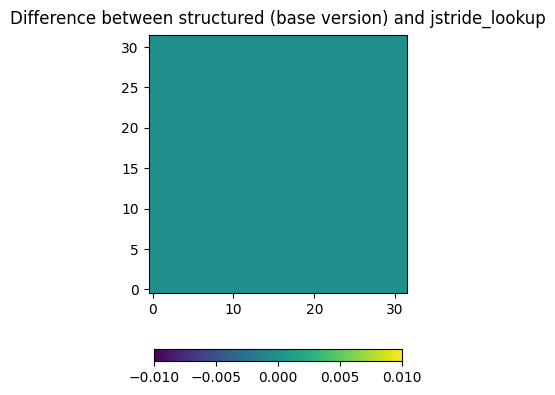

In [8]:
# Run and validate a single version
run_and_validate(["jstride_lookup"])

Output for version: structured
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.4118455E-01], \
] )
Runtime structured = 0.0412 sec
Total memory access measured = 1.385 GB
Total DRAM access measured = 0.004 GB
Total flops measured = 164295010.000 flop
Corrected number of flops = 164295010.000 flop
Arithmetic intensity = 0.119 flops/byte

Output for version: jstride_lookup
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.1079881E+00], \
] )
Runtime jstride_lookup = 0.1080 sec
Total memory access measured = 3.350 GB
Total DRAM access measured = 0.004 GB
Total flops measured = 151477780.000 flop
Corrected number of flops = 151477780.000 flop
Arithmetic intensity = 0.045 flops/byte

Output for version: zcurve_lookup
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.1058370E+00], \
] )
Runtime zcurve_lookup = 0.1058 sec
Total memory access measured = 3.353 GB
Total DRAM 

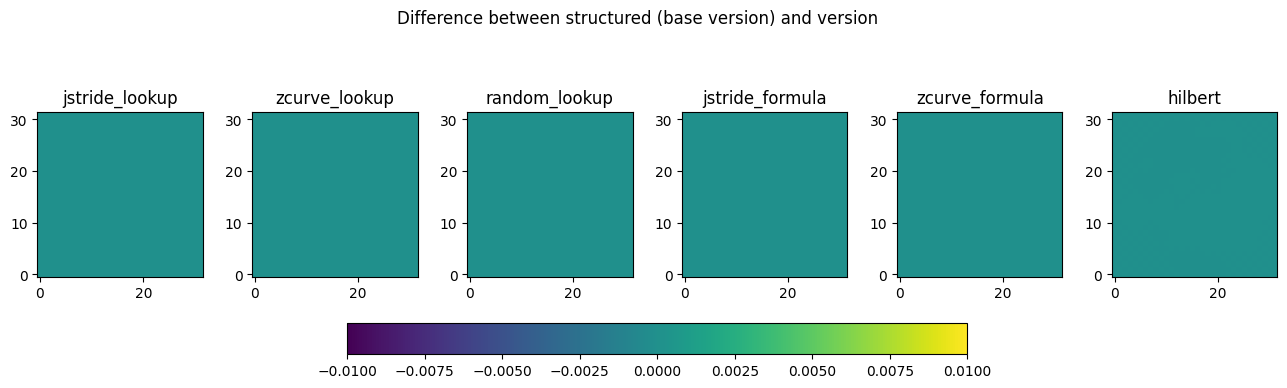

In [9]:
# !!! The execution of this cell takes about 6min for nx, ny, nz, iter = 128, 128, 64, 1024
# (in case you want less runtime, comment "zcurve_formula" in the previously defined versions list)

# Run and validate all versions (previously defined list)
run_and_validate(versions)

## Plots of single executions

#### Memory

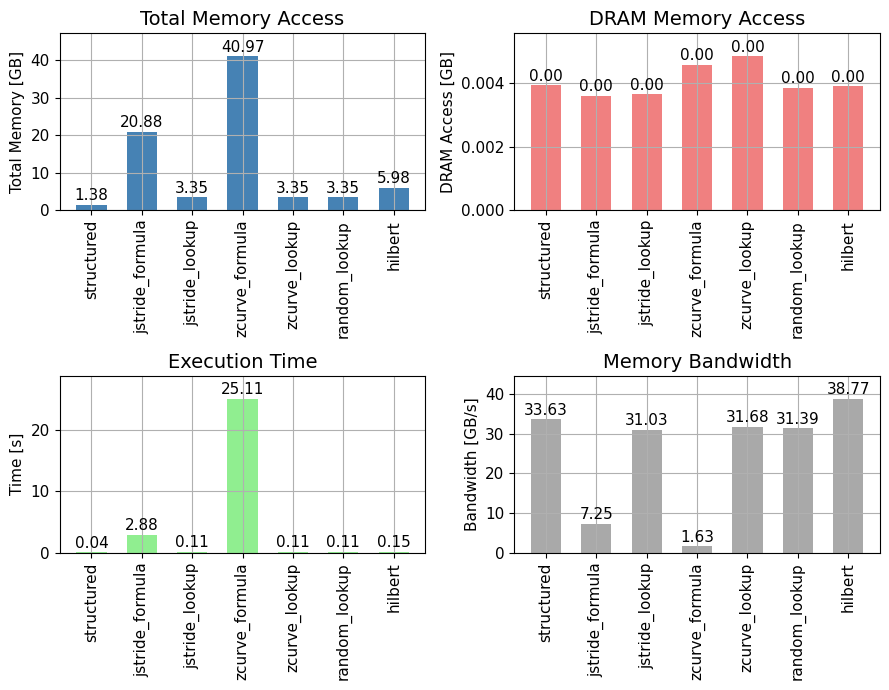

In [10]:
# Version labels
versions = ["structured", "jstride_formula", "jstride_lookup", "zcurve_formula", "zcurve_lookup", "random_lookup", "hilbert"]

# Data
total_GB = [total_GB_structured, total_GB_jstride_formula, total_GB_jstride_lookup, total_GB_zcurve_formula, total_GB_zcurve_lookup, total_GB_random_lookup, total_GB_hilbert]
total_GB_DRAM = [total_GB_DRAM_structured, total_GB_DRAM_jstride_formula, total_GB_DRAM_jstride_lookup, total_GB_DRAM_zcurve_formula, total_GB_DRAM_zcurve_lookup, total_GB_DRAM_random_lookup, total_GB_DRAM_hilbert]
time_s = [time_structured, time_jstride_formula, time_jstride_lookup, time_zcurve_formula, time_zcurve_lookup, time_random_lookup, time_hilbert]

# Compute bandwidth (Total memory only)
bandwidth = [gb / t if t != 0 else 0 for gb, t in zip(total_GB, time_s)]

x = np.arange(len(versions))
width = 0.6

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = axs.flatten()

# Helper function to annotate bars
def annotate_bars(ax, values):
    for i, val in enumerate(values):
        ax.text(i, val + 0.01 * max(values), f"{val:.2f}", ha='center', va='bottom', fontsize=11)

# Plot 1: Total memory access
axs[0].bar(x, total_GB, width, color='steelblue')
annotate_bars(axs[0], total_GB)
axs[0].set_ylim(0, max(total_GB) + 0.15 * max(total_GB))
axs[0].tick_params(axis='y', labelsize=11)
axs[0].set_ylabel("Total Memory [GB]", fontsize = 11)
axs[0].set_title("Total Memory Access", fontsize = 14)
axs[0].grid(True)

# Plot 2: DRAM memory access
axs[1].bar(x, total_GB_DRAM, width, color='lightcoral')
annotate_bars(axs[1], total_GB_DRAM)
axs[1].set_ylim(0, max(total_GB_DRAM) + 0.15 * max(total_GB_DRAM))
axs[1].tick_params(axis='y', labelsize=11)
axs[1].set_ylabel("DRAM Access [GB]", fontsize = 11)
axs[1].set_title("DRAM Memory Access", fontsize = 14)
axs[1].grid(True)

# Plot 3: Execution time
axs[2].bar(x, time_s, width, color='lightgreen')
annotate_bars(axs[2], time_s)
axs[2].set_ylim(0, max(time_s) + 0.15 * max(time_s))
axs[2].tick_params(axis='y', labelsize=11)
axs[2].set_ylabel("Time [s]", fontsize = 11)
axs[2].set_title("Execution Time", fontsize = 14)
axs[2].grid(True)

# Plot 4: Bandwidth
axs[3].bar(x, bandwidth, width, color='darkgray')
annotate_bars(axs[3], bandwidth)
axs[3].set_ylim(0, max(bandwidth) + 0.15 * max(bandwidth))
axs[3].tick_params(axis='y', labelsize=11)
axs[3].set_ylabel("Bandwidth [GB/s]", fontsize = 11)
axs[3].set_title("Memory Bandwidth", fontsize = 14)
axs[3].grid(True)

# Set x-tick labels for all plots
for ax in axs:
    ax.set_xticks(x)
    ax.set_xticklabels(versions, rotation=90, fontsize = 11)

plt.tight_layout()
plt.savefig(f"plots/memory_{nx_cluster}.png", dpi=300, bbox_inches='tight')
plt.show()


#### Arithmetic intensity

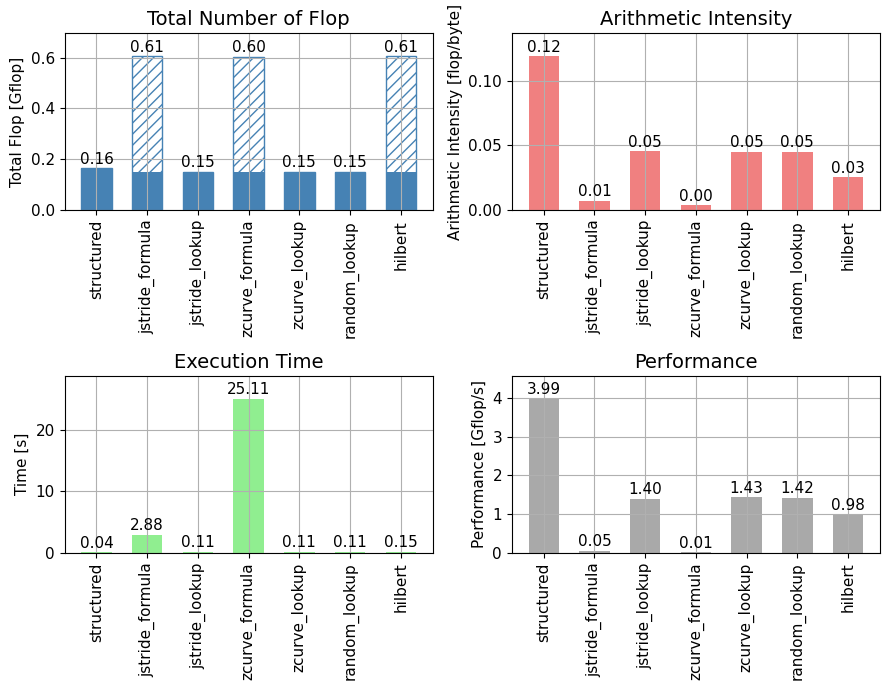

In [11]:
# Version labels
versions = ["structured", "jstride_formula", "jstride_lookup", "zcurve_formula", "zcurve_lookup", "random_lookup", "hilbert"]

# Data
total_flops = [total_flops_structured, total_flops_jstride_formula, total_flops_jstride_lookup, total_flops_zcurve_formula, total_flops_zcurve_lookup, total_flops_random_lookup, total_flops_hilbert]
flops_G = np.array(total_flops) / 1e9
corrected_flops = [corrected_flops_structured, corrected_flops_jstride_formula, corrected_flops_jstride_lookup, corrected_flops_zcurve_formula, corrected_flops_zcurve_lookup, corrected_flops_random_lookup, corrected_flops_hilbert]
corrected_flops_G = np.array(corrected_flops) / 1e9
arithmetic_intensity = [arithmetic_intensity_structured, arithmetic_intensity_jstride_formula, arithmetic_intensity_jstride_lookup, arithmetic_intensity_zcurve_formula, arithmetic_intensity_zcurve_lookup, arithmetic_intensity_random_lookup, arithmetic_intensity_hilbert]
time_s = [time_structured, time_jstride_formula, time_jstride_lookup, time_zcurve_formula, time_zcurve_lookup, time_random_lookup, time_hilbert]

# Compute performance (Gflop/s)
performance = [(flops/1e9) / t if t != 0 else 0 for flops, t in zip(corrected_flops, time_s)]

x = np.arange(len(versions))
width = 0.6

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = axs.flatten()

# Helper function to annotate bars
def annotate_bars(ax, values):
    for i, val in enumerate(values):
        ax.text(i, val + 0.01 * max(values), f"{val:.2f}", ha='center', va='bottom', fontsize=11)

# Plot 1: Total number of flops and corrected number of flops
axs[0].bar(x, corrected_flops_G, width, color='steelblue')
axs[0].bar(x, flops_G, width, color='none', edgecolor='steelblue', hatch='///')
annotate_bars(axs[0], flops_G)
axs[0].set_ylim(0, max(flops_G) + 0.15 * max(flops_G))
axs[0].tick_params(axis='y', labelsize=11)
axs[0].set_ylabel("Total Flop [Gflop]", fontsize = 11)
axs[0].set_title("Total Number of Flop", fontsize = 14)
axs[0].grid(True)

# Plot 2: Arithmetic intensity
axs[1].bar(x, arithmetic_intensity, width, color='lightcoral')
annotate_bars(axs[1], arithmetic_intensity)
axs[1].set_ylim(0, max(arithmetic_intensity) + 0.15 * max(arithmetic_intensity))
axs[1].tick_params(axis='y', labelsize=11)
axs[1].set_ylabel("Arithmetic Intensity [flop/byte]", fontsize = 11)
axs[1].set_title("Arithmetic Intensity", fontsize = 14)
axs[1].grid(True)

# Plot 3: Execution time
axs[2].bar(x, time_s, width, color='lightgreen')
annotate_bars(axs[2], time_s)
axs[2].set_ylim(0, max(time_s) + 0.15 * max(time_s))
axs[2].tick_params(axis='y', labelsize=11)
axs[2].set_ylabel("Time [s]", fontsize = 11)
axs[2].set_title("Execution Time", fontsize = 14)
axs[2].grid(True)

# Plot 4: Performance
axs[3].bar(x, performance, width, color='darkgray')
annotate_bars(axs[3], performance)
axs[3].set_ylim(0, max(performance) + 0.15 * max(performance))
axs[3].tick_params(axis='y', labelsize=11)
axs[3].set_ylabel("Performance [Gflop/s]", fontsize = 11)
axs[3].set_title("Performance", fontsize = 14)
axs[3].grid(True)

# Set x-tick labels for all plots
for ax in axs:
    ax.set_xticks(x)
    ax.set_xticklabels(versions, rotation=90, fontsize = 11)

plt.tight_layout()
plt.savefig(f"plots/arithmetics_{nx_cluster}.png", dpi=300, bbox_inches='tight')
plt.show()

## Roofline model

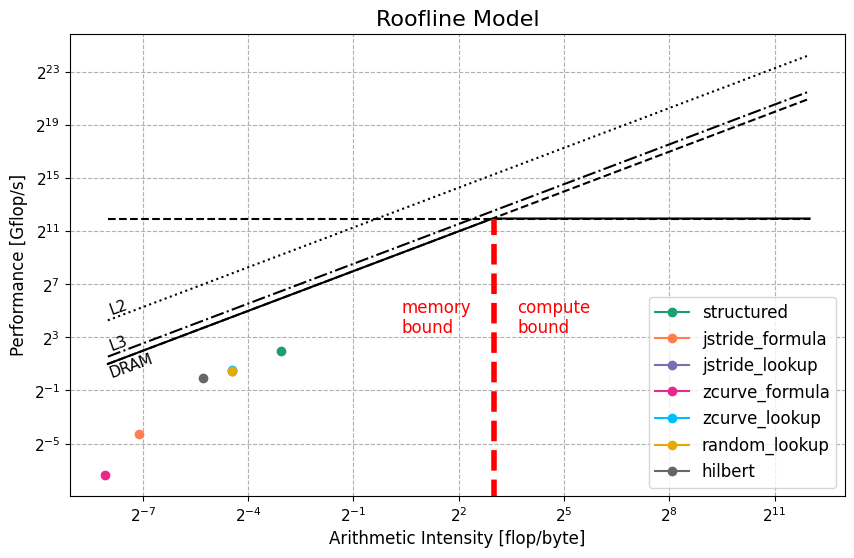

In [12]:
# Set-up of roofline model

# Computing peak performance and peak bandwidth for different memories as well as DRAM roofline
operational_intensity = 2 ** np.linspace(-8, 12, 100)
peak_performance_in_gflops = 2 * 3465 * 1e6 * 72 * 8 * 1.e-9 # 2 * number_of_cores * clock_frequency * n 
peak_bandwidth_in_gbs_DRAM = 2 * 4000.0e6 * 32 * 16 / 8 / 1e9 # 2 * memory_clock_frequency * n_channels * width
peak_bandwidth_in_gbs_L3 = 750 # literature value
peak_bandwidth_in_gbs_L2 = 5 * 1000 # literature value
roofline = np.minimum( operational_intensity * peak_bandwidth_in_gbs_DRAM, peak_performance_in_gflops )

# Setting up the figure
fig, ax = plt.subplots(figsize=(10,6))
plt.grid(True, which="both", ls='--');
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
xlim = ( np.min(operational_intensity), np.max(operational_intensity) )
ylim = ( 0.25 * np.min(roofline), 4 * peak_performance_in_gflops )

# Plotting roofline, other ceilings, and memory-compute boundary
ax.plot( operational_intensity, roofline, 'k-');
ax.plot( operational_intensity, np.repeat(peak_performance_in_gflops, 100), 'k', linestyle="dashed" );
ax.plot( operational_intensity, operational_intensity * peak_bandwidth_in_gbs_DRAM, 'k', linestyle="dashed" );
ax.plot( operational_intensity, operational_intensity * peak_bandwidth_in_gbs_L3, 'k', linestyle="dashdot" );
ax.plot( operational_intensity, operational_intensity * peak_bandwidth_in_gbs_L2, 'k', linestyle="dotted" );
ax.plot( [8,8], [0, peak_performance_in_gflops ], 'r', linewidth=4, linestyle="dashed")

# figure labels
ax.text( operational_intensity [0], 1.0, "DRAM", rotation = 20, fontsize = 11)
ax.text( operational_intensity [0], 4.0, "L3", rotation = 20, fontsize = 11)
ax.text( operational_intensity [0], 26.0, "L2", rotation = 20, fontsize = 11)
ax.text( 1.3, 10, 'memory\nbound', color='red', fontsize=12)
ax.text( 12.8, 10, 'compute\nbound', color='red', fontsize=12);
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
plt.title("Roofline Model", fontsize = 16);
plt.xlabel("Arithmetic Intensity [flop/byte]", fontsize = 12);
plt.ylabel("Performance [Gflop/s]", fontsize = 12);

# Definition of color palette
my_palette = ["#1b9e77", "#FF7F50", "#7570b3", 
              "#e7298a", "#00BFFF", "#e6ab02", "#666666"]
sns.set_palette(my_palette)

# Addition of data points
for i in range(len(versions)):
    intensity = arithmetic_intensity[i]
    performance = (corrected_flops[i]/1e9)/time_s[i]
    ax.plot(intensity, performance, marker = '.', color=my_palette[i], markersize = 12, label = versions[i])
    
ax.legend(fontsize = 12);

fig.savefig(f"plots/roofline_model_{nx_cluster}.png", dpi=300, bbox_inches="tight")
plt.show()

## $r$ executions of all versions

In this section, all versions are executed $r$-times. There is no longer a validation of the versions as they have been validated before.   
$r$ can be changed, however it has to be considered that the runtime of the code is approximately $r \cdot 25$ min.

In [13]:
# Choice of versions
versions = [
    "structured",
    "jstride_formula",
    "jstride_lookup",
    "zcurve_formula",
    "zcurve_lookup",
    "random_lookup",
    "hilbert"
]

# Definition of grid size, number of vertical levels, and number of iterations
nx_cluster, ny_cluster, nz_cluster, iters_cluster = 32, 32, 64, 1024
nx_local, ny_local, nz_local, iters_local = 32, 32, 16, 16

In [14]:
# Results per version
timings = {}
total_GB = {}
total_GB_DRAM = {}
total_flops = {}
corrected_flops = {}
arithmetic_intensity = {}

def run_rtimes_version(version, r = 3):  # You can change default r to the number of runs you want
    # Compile
    with io.capture_output() as _:
        !make clean
        !make VERSION={version}

    # Initialize lists to store results per version
    timings[version] = []
    total_GB[version] = []
    total_GB_DRAM[version] = []
    total_flops[version] = []
    corrected_flops[version] = []
    arithmetic_intensity[version] = []

    for i in range(r):
        print(f"\n--- Run {i+1}/{r} for version: {version} ---")

        exe = f"./stencil2d-{version}.x"

        # Run executable and extract timing
        if "SLURM_JOB_ID" in os.environ:
            output = !srun -n 1 {exe} --nx {nx_cluster} --ny {ny_cluster} --nz {nz_cluster} --num_iter {iters_cluster}
        else:
            print(f"# WARNING: Local execution for {version}")
            output = !{exe} --nx {nx_local} --ny {ny_local} --nz {nz_local} --num_iter {iters_local}

        # Print and exec result line
        print(f"\nOutput for version: {version}")
        print(output.nlstr)
        exec(output.nlstr, globals())
    
        # Extract runtime
        runtime = data[0, -1]
        timings[version].append(runtime)

        # Run for performance assessment
        with io.capture_output() as _:
            if "SLURM_JOB_ID" in os.environ:
                !srun -n 1 ./perf_wrap.sh {exe} --nx {nx_cluster} --ny {ny_cluster} --nz {nz_cluster} --num_iter {iters_cluster}
            else:
                !srun -n 1 ./perf_wrap.sh {exe} --nx {nx_local} --ny {ny_local} --nz {nz_local} --num_iter {iters_local}

        # Store performance assessment
        dram_bytes, total_bytes, flops = parse_perf_stat()
        total_GB[version].append(total_bytes / 1e9)
        total_GB_DRAM[version].append(dram_bytes / 1e9)
        total_flops[version].append(flops)
        
        # Correct number of flops for versions with too high flop count
        if version == "jstride_formula" or version == "zcurve_formula" or version == "hilbert": # correcting number of flops for these versions
            if lookup_list: # if lookup versions available, corrected number of flops is mean of these versions
                run_index = len(corrected_flops[version])  # index to access correct run
                corrected_value = np.mean([total_flops[v][run_index] for v in lookup_list])
            else: # if no lookup version, then number of flops is inilining value
                run_index = len(corrected_flops[version])  # index to access correct run
                corrected_value = total_flops["structured"][run_index]  
        else:
            corrected_value = flops # no need to correct number of flops for other versions (already correct)
        
        corrected_flops[version].append(corrected_value)
        
        arithmetic_intensity[version].append(corrected_value / total_bytes if total_bytes > 0 else 0.0)

        if version == "jstride_formula" or version == "zcurve_formula" or version == "hilbert":
            print(f"Runtime: {runtime:.4f} s | Mem: {total_bytes / 1e9:.2f} GB | DRAM: {dram_bytes / 1e9:.2f} GB | Flops: {flops:.2e} | Flops corrected: {corrected_value:.2e} | AI: {corrected_value / total_bytes:.3f}")
        else:
            print(f"Runtime: {runtime:.4f} s | Mem: {total_bytes / 1e9:.2f} GB | DRAM: {dram_bytes / 1e9:.2f} GB | Flops: {flops:.2e} | AI: {flops / total_bytes:.3f}")


In [15]:
# Number of runs per version
r = 10

# Ensure structured is first in the version list, add structured in case it is missing
versions = ["structured"] + [v for v in versions if v != "structured"]

# Ordering of versions: structured, look-up, formula
versions, lookup_list = reposition_lookup(versions, "lookup")

# Run all versions r times
for v in versions:
    run_rtimes_version(v, r)


--- Run 1/10 for version: structured ---

Output for version: structured
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.4120324E-01], \
] )
Runtime: 0.0412 s | Mem: 1.38 GB | DRAM: 0.00 GB | Flops: 1.64e+08 | AI: 0.119

--- Run 2/10 for version: structured ---

Output for version: structured
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.4110670E-01], \
] )
Runtime: 0.0411 s | Mem: 1.39 GB | DRAM: 0.00 GB | Flops: 1.64e+08 | AI: 0.119

--- Run 3/10 for version: structured ---

Output for version: structured
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.4116058E-01], \
] )
Runtime: 0.0412 s | Mem: 1.39 GB | DRAM: 0.00 GB | Flops: 1.64e+08 | AI: 0.118

--- Run 4/10 for version: structured ---

Output for version: structured
# ranks nx ny nz num_iter time
data = np.array( [ \
[    1,   32,   32,   64,    1024,  0.4110123E-01], \
] )
Runtime: 0.0411 s | Mem: 1.

## Boxplots

#### Memory

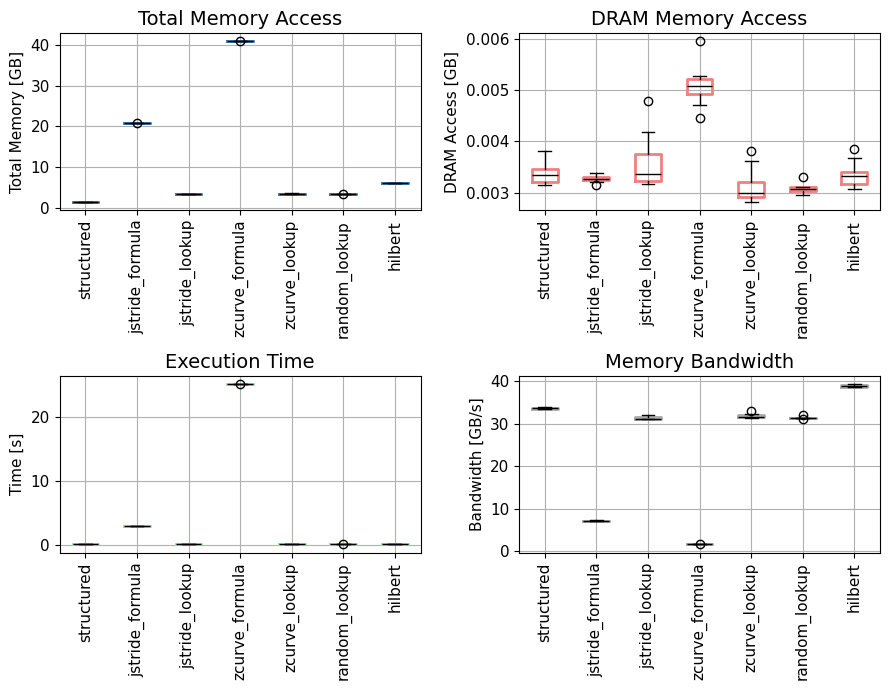

In [16]:
# Version labels
versions = ["structured", "jstride_formula", "jstride_lookup", "zcurve_formula", "zcurve_lookup", "random_lookup", "hilbert"]

# Convert from dicts-of-lists to ordered lists of lists
time_samples = [timings[v] for v in versions]
mem_samples = [total_GB[v] for v in versions]
dram_samples = [total_GB_DRAM[v] for v in versions]
bw_samples = [[m / t if t != 0 else 0 for m, t in zip(mem, time)] for mem, time in zip(mem_samples, time_samples)]

# Helper function to set line colors
def set_box_colors(bp, box_color):
    # Color only the boxes
    for item in bp['boxes']:
        item.set_color(box_color)
        item.set_linewidth(2)

    # Color whiskers, caps, and medians in black
    for element in ['whiskers', 'caps', 'medians']:
        for item in bp[element]:
            item.set_color('black')
            item.set_linewidth(1)

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = axs.flatten()

# Plot 1: Total memory access
bp = axs[0].boxplot(mem_samples, patch_artist=False)
set_box_colors(bp, 'steelblue')
axs[0].tick_params(axis='y', labelsize=11)
axs[0].set_ylabel("Total Memory [GB]", fontsize = 11)
axs[0].set_title("Total Memory Access", fontsize = 14)
axs[0].grid(True)

# Plot 2: DRAM memory access
bp = axs[1].boxplot(dram_samples, patch_artist=False)
set_box_colors(bp, 'lightcoral')
axs[1].tick_params(axis='y', labelsize=11)
axs[1].set_ylabel("DRAM Access [GB]", fontsize = 11)
axs[1].set_title("DRAM Memory Access", fontsize = 14)
axs[1].grid(True)

# Plot 3: Execution time
bp = axs[2].boxplot(time_samples, patch_artist=False)
set_box_colors(bp, 'lightgreen')
axs[2].tick_params(axis='y', labelsize=11)
axs[2].set_ylabel("Time [s]", fontsize = 11)
axs[2].set_title("Execution Time", fontsize = 14)
axs[2].grid(True)

# Plot 4: Bandwidth
bp = axs[3].boxplot(bw_samples, patch_artist=False)
set_box_colors(bp, 'darkgray')
axs[3].tick_params(axis='y', labelsize=11)
axs[3].set_ylabel("Bandwidth [GB/s]", fontsize = 11)
axs[3].set_title("Memory Bandwidth", fontsize = 14)
axs[3].grid(True)

# Set x-tick labels for all plots
for ax in axs:
    ax.set_xticks(np.arange(1, len(versions) + 1))
    ax.set_xticklabels(versions, rotation=90, fontsize = 11)

plt.tight_layout()
plt.savefig(f"plots/memory_boxplots_{nx_cluster}.png", dpi=300, bbox_inches='tight')
plt.show()


#### Arithmetics

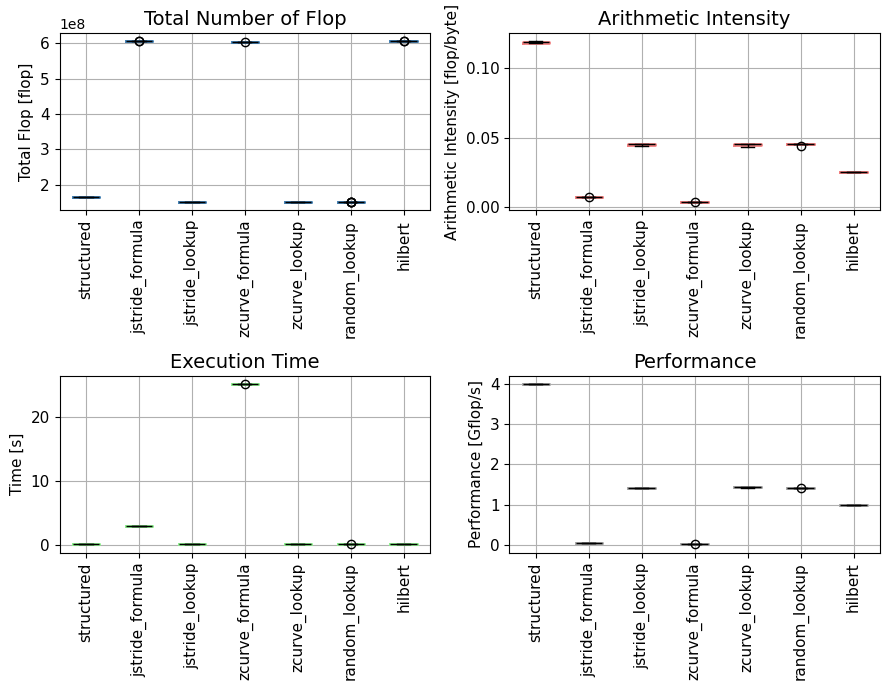

In [17]:
# Version labels
versions = ["structured", "jstride_formula", "jstride_lookup", "zcurve_formula", "zcurve_lookup", "random_lookup", "hilbert"]
versions_corr = ["jstride_formula", "zcurve_formula", "hilbert"]

# Convert from dicts-of-lists to ordered lists of lists
time_samples = [timings[v] for v in versions]
flop_samples = [total_flops[v] for v in versions]
flop_samples_corr = [corrected_flops[v] * len(total_flops[v]) if v in versions_corr 
                     else total_flops[v] for v in versions]
ai_samples = [arithmetic_intensity[v] for v in versions]
perf_samples = [[(flop/1e9) / t if t != 0 else 0 for flop, t in zip(flop, time)] for flop, time in zip(flop_samples_corr, time_samples)]

# Helper function to set line colors
def set_box_colors(bp, box_color):
    # Color only the boxes
    for item in bp['boxes']:
        item.set_color(box_color)
        item.set_linewidth(2)

    # Color whiskers, caps, and medians in black
    for element in ['whiskers', 'caps', 'medians']:
        for item in bp[element]:
            item.set_color('black')
            item.set_linewidth(1)

# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = axs.flatten()

# Plot 1: Total flops
bp = axs[0].boxplot(flop_samples, patch_artist=False)
set_box_colors(bp, 'steelblue')
axs[0].tick_params(axis='y', labelsize=11)
axs[0].set_ylabel("Total Flop [flop]", fontsize = 11)
axs[0].set_title("Total Number of Flop", fontsize = 14)
axs[0].grid(True)

# Plot 2: AI
bp = axs[1].boxplot(ai_samples, patch_artist=False)
set_box_colors(bp, 'lightcoral')
axs[1].tick_params(axis='y', labelsize=11)
axs[1].set_ylabel("Arithmetic Intensity [flop/byte]", fontsize = 11)
axs[1].set_title("Arithmetic Intensity", fontsize = 14)
axs[1].grid(True)

# Plot 3: Execution time
bp = axs[2].boxplot(time_samples, patch_artist=False)
set_box_colors(bp, 'lightgreen')
axs[2].tick_params(axis='y', labelsize=11)
axs[2].set_ylabel("Time [s]", fontsize = 11)
axs[2].set_title("Execution Time", fontsize = 14)
axs[2].grid(True)

# Plot 4: Performance
bp = axs[3].boxplot(perf_samples, patch_artist=False)
set_box_colors(bp, 'darkgray')
axs[3].tick_params(axis='y', labelsize=11)
axs[3].set_ylabel("Performance [Gflop/s]", fontsize = 11)
axs[3].set_title("Performance", fontsize = 14)
axs[3].grid(True)

# Set x-tick labels for all plots
for ax in axs:
    ax.set_xticks(np.arange(1, len(versions) + 1))
    ax.set_xticklabels(versions, rotation=90, fontsize = 11)

plt.tight_layout()
plt.savefig(f"plots/arithmetics_boxplots_{nx_cluster}.png", dpi=300, bbox_inches='tight')
plt.show()
